In [80]:
import pandas as pd
# github link = https://github.com/codebasics/potato-disease-classification

In [18]:
import os

In [19]:
os.getcwd()

'C:\\Users\\Prasa\\OneDrive\\Documents'

In [20]:
os.chdir("C:\\Users\\Prasa\\OneDrive\\Documents")

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [22]:
import matplotlib.pyplot as plt

In [23]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [25]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [26]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())

In [27]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch[0].numpy())

In [28]:
# for one image...


# for image_batch, label_batch in dataset.take(1):
#     plt.imshow(image_batch[0].numpy().astype("uint8"))
#     plt.axis("off")
#     plt.title(class_names[label_batch[0]])

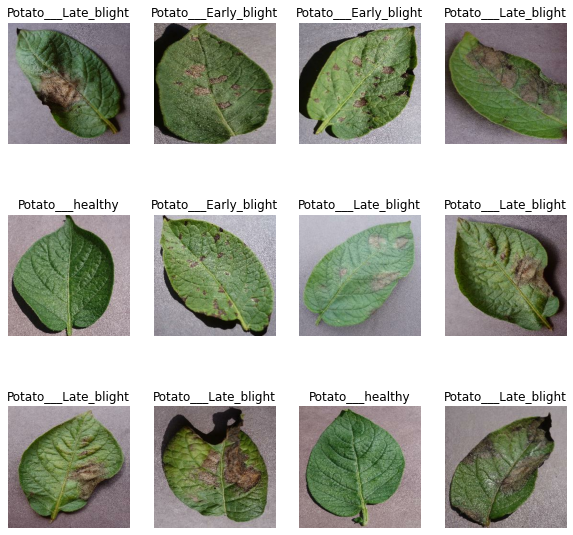

In [29]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        


In [30]:
len(dataset)

68

In [31]:
68*32

2176

In [32]:
# 80% - training
# 20% - testing (10% - validations, 10% - testing)

In [33]:
train_size = 0.8
len(dataset)*train_size
# this is our training data percent

54.400000000000006

In [34]:
train_ds = dataset.take(54)  # in python its slicing the array [:54]
len(train_ds)

54

In [35]:
test_ds = dataset.skip(54)  # similarly, [54:]
len(test_ds)
# in this 20% of test dataset, 10% is validation and 10% is testing

14

In [36]:
val_size = 0.1
len(dataset)*val_size

# so we need this much amount of samples for validations and similarly for testing.

6.800000000000001

In [37]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [38]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [39]:
def get_dataset_partitions_tf(ds,  train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

        
    
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

54

In [42]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [44]:
# got through tensorflow pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [47]:
# make the images to be scaling. 
# generally the range is 0 to 256. 
# So divide it by 255, so the range will be in 0 to 1.

In [48]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size =(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
])

model.build(input_shape=input_shape)

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [52]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [53]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 114s 2s/step - loss: 0.9148 - accuracy: 0.4826 - val_loss: 0.8601 - val_accuracy: 0.6771
Epoch 2/30
54/54 [==============================] - 103s 2s/step - loss: 0.6824 - accuracy: 0.6771 - val_loss: 0.5605 - val_accuracy: 0.7396
Epoch 3/30
54/54 [==============================] - 101s 2s/step - loss: 0.5654 - accuracy: 0.7569 - val_loss: 0.4360 - val_accuracy: 0.8177
Epoch 4/30
54/54 [==============================] - 97s 2s/step - loss: 0.4445 - accuracy: 0.7992 - val_loss: 0.4247 - val_accuracy: 0.8490
Epoch 5/30
54/54 [==============================] - 97s 2s/step - loss: 0.3609 - accuracy: 0.8524 - val_loss: 0.2596 - val_accuracy: 0.8698
Epoch 6/30
54/54 [==============================] - 700s 13s/step - loss: 0.3148 - accuracy: 0.8808 - val_loss: 0.1990 - val_accuracy: 0.9219
Epoch 7/30
54/54 [==============================] - 99s 2s/step - loss: 0.2787 - accuracy: 0.8877 - val_loss: 0.2248 - val_accuracy: 0.9010
Epoch 8/30
54/5

In [54]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 349ms/step - loss: 0.0437 - accuracy: 0.9844


In [55]:
scores

[0.043697159737348557, 0.984375]

In [56]:
history

In [57]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history.history["accuracy"]

[0.4826388955116272,
 0.6770833134651184,
 0.7569444179534912,
 0.7991898059844971,
 0.8524305820465088,
 0.8807870149612427,
 0.8877314925193787,
 0.90625,
 0.9317129850387573,
 0.9502314925193787,
 0.9450231194496155,
 0.9664351940155029,
 0.9733796119689941,
 0.9386574029922485,
 0.9722222089767456,
 0.9803240895271301,
 0.9814814925193787,
 0.9780092835426331,
 0.9861111044883728,
 0.9780092835426331,
 0.9855324029922485,
 0.9878472089767456,
 0.9693287014961243,
 0.9849537014961243,
 0.9699074029922485,
 0.9849537014961243,
 0.9884259104728699,
 0.9832175970077515,
 0.9826388955116272,
 0.9832175970077515]

In [60]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# loss is nothing but, error in the back propogation keeps on reducing as it proceed forward in our epochs.
loss = history.history["loss"]
val_loss  = history.history["val_loss"]

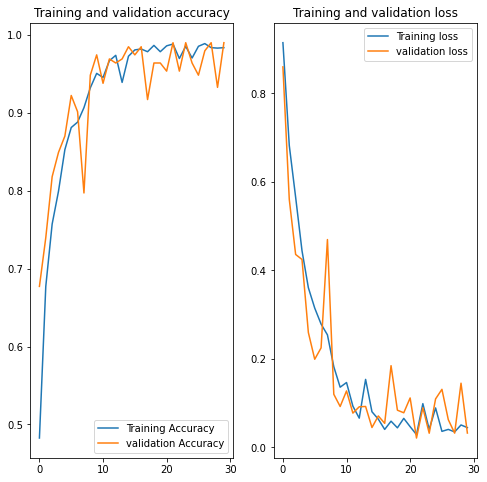

In [61]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label= "Training loss")
plt.plot(range(EPOCHS), val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.title("Training and validation loss")
plt.show()

first image to predict
first image's actual label: Potato___Late_blight
predicted label: Potato___Late_blight


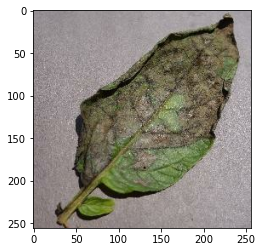

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
   #print(batch_prediction[0])
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    # since our final result in model is of 3 classes (n_classes) and also 
    # having softmax as activation so it gives the 3D array. 
    # so in that array, which is having the high probability, it is the class.

In [64]:
import numpy as np
np.argmax([7.4839557e-04, 9.9888629e-01, 3.6534935e-04])
#  gives the index with high probability.

1

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # creating a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

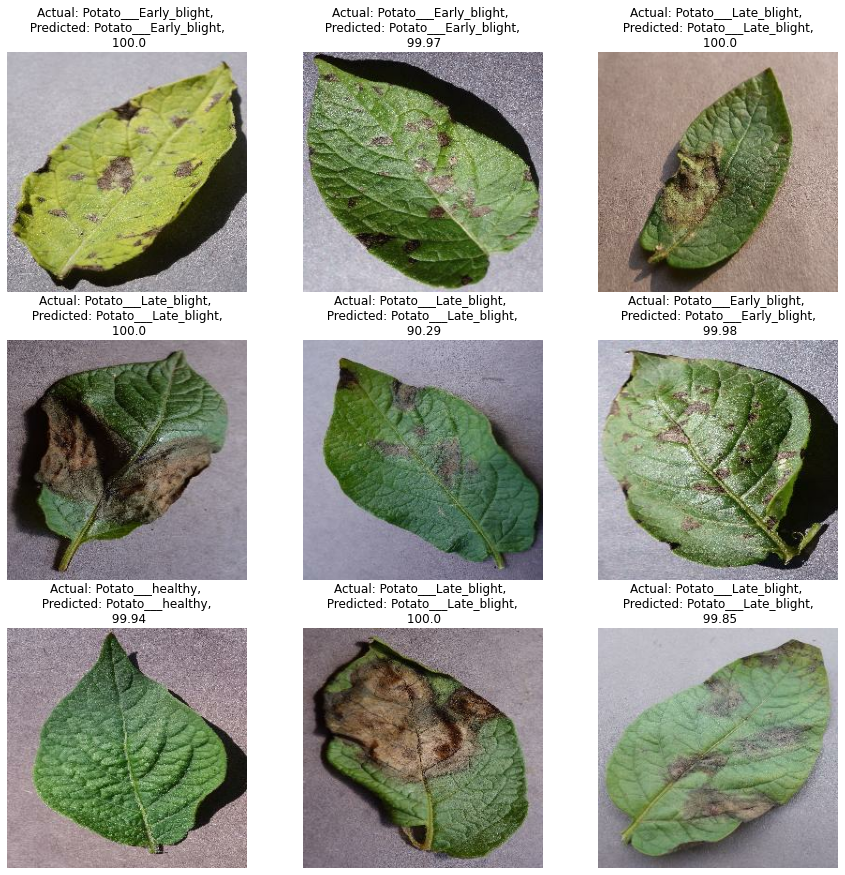

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n {confidence}")
        
        plt.axis("off")

In [69]:
os.getcwd()

'C:\\Users\\Prasa\\OneDrive\\Documents'

In [76]:
# model_version = 2
# model.save(f"C:/Users/Prasa/potato-disease/models/{model_version}")

In [77]:
os.listdir("../models/")

['1']

In [79]:
# instead of giving version count manually, 
# we can give a for loop, that will auto increment.

model_version = max([int(i) for i in os.listdir("C:/Users/Prasa/potato-disease/models/") + [0]]) + 1
model.save(f"C:/Users/Prasa/potato-disease/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/Prasa/potato-disease/models/3\assets
